<a href="https://colab.research.google.com/github/praveentn/MidcurveNN/blob/master/simple_encdec/notebook_simple_encoderdecoder_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simple EncoderDecoder

In [1]:
# mount google drive & set working directory
# requires auth (click on url & copy token into text box when prompted)
from google.colab import drive
drive.mount("/content/gdrive")

import os
print(os.getcwd())

os.chdir('/content/gdrive/My Drive/Colab Notebooks/MidcurveNN')
!pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content
/content/gdrive/My Drive/Colab Notebooks/MidcurveNN


## Installations

In [0]:
# requirements = """
# keras
# git+https://www.github.com/keras-team/keras-contrib.git
# matplotlib
# numpy
# scipy
# pillow
# #urllib
# #skimage
# scikit-image
# #gzip
# #pickle
# """
# %store requirements > requirements.txt

In [3]:
# !pip install -r requirements.txt
!pip install drawSvg

## Import TensorFlow and other libraries

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

# !pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.preprocessing.image import img_to_array, load_img
from random import shuffle

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers, optimizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam,RMSprop,SGD
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten,AveragePooling2D,UpSampling2D
from keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from random import shuffle

from keras.models import Model, load_model
#from prepare_data import get_training_data
#from prepare_plots import plot_results
import random

import PIL
import json
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use('TKAgg')
%matplotlib inline

Using TensorFlow backend.


## Load the dataset

Steps to generate URL used below:
- Say, your data files are in the directory called 'input'
- Manually create a zip file, 'input.zip'
- Sync it to gDrive
- In gDrive, Share it with Public model, copy its share-able link
- Use https://sites.google.com/site/gdocs2direct/ to generate corresponding Direct link
- Paste it below

In [5]:
# test PIL installation
import sys
from PIL import Image
sys.modules['Image'] = Image

# both should point to same dir
from PIL import Image
print(Image.__file__)

import Image
print(Image.__file__)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py
/usr/local/lib/python3.6/dist-packages/PIL/Image.py


In [6]:
# _URL = 'https://drive.google.com/uc?export=download&id=16rqDFLO__WySSQGlAht0FEj2uJZg4M9M'

# path_to_zip = tf.keras.utils.get_file('input.zip',
#                                       origin=_URL,
#                                       extract=True)

# working directory
wdir = os.getcwd()
print("Working directory: ", wdir)

# input_data_folder = os.path.join(os.path.dirname(path_to_zip), 'input')
input_data_folder = wdir + "/data/input"
input_data_folder = wdir + "/data/images"
print("input data dir: ", input_data_folder)

Working directory:  /content/gdrive/My Drive/Colab Notebooks/MidcurveNN
input data dir:  /content/gdrive/My Drive/Colab Notebooks/MidcurveNN/data/images


In [8]:
import glob

image_paths = glob.glob(input_data_folder + '/**/*.png', recursive=True)
images = [os.path.basename(img_path) for img_path in image_paths]

print(len(images))

#images = os.listdir(input_data_folder)
images[99]

6048


'CapI_Midcurve_mirrored_0_translated_10_-20.png'

In [0]:
imdim = 100

In [10]:
shapes = os.listdir('/content/gdrive/My Drive/Colab Notebooks/MidcurveNN/data/images')
shapes

['CapI',
 'Iuvw',
 'Tuvw',
 'Vuvw',
 'Sm_n',
 'InvV',
 'Parl',
 'Trap',
 'Stik',
 'Usla',
 'LapT',
 'RelY',
 'T002',
 'T003',
 'T004',
 'T005',
 'Plus',
 'SqLu',
 'Luvw',
 'L001',
 'L002',
 'L003',
 'T006',
 'X001',
 'L004',
 'Y001',
 'L100']

In [0]:
def read_input_image_pairs(datafolder=input_data_folder):
    profile_pngs = []
    midcurve_pngs = []
    for file in os.listdir(datafolder):
        fullpath = os.path.join(datafolder, file)
        if os.path.isdir(fullpath):
            continue
        if file.endswith(".png"):
            if file.find("Profile") != -1:
                profile_pngs.append(fullpath)
            if file.find("Midcurve") != -1:
                midcurve_pngs.append(fullpath)
    profile_pngs = sorted(profile_pngs)
    midcurve_pngs = sorted(midcurve_pngs)
    return profile_pngs,midcurve_pngs

In [0]:
def get_training_data(datafolder=input_data_folder):
    profile_pngs,midcurve_pngs = read_input_image_pairs(datafolder)
    
    profile_pngs_objs = [img_to_array(load_img(f, color_mode='rgba', target_size=(imdim, imdim))) for f in profile_pngs ]
    midcurve_pngs_objs = [img_to_array(load_img(f, color_mode='rgba', target_size=(imdim, imdim))) for f in midcurve_pngs]

#     profile_pngs_objs = np.array([x.reshape((1,) + x.shape) for x in profile_pngs_objs])
#     midcurve_pngs_objs = np.array([x.reshape((1,) + x.shape) for x in midcurve_pngs_objs])

    profile_pngs_gray_objs = [x[:,:,3] for x in profile_pngs_objs]
    midcurve_pngs_gray_objs =[x[:,:,3] for x in midcurve_pngs_objs]
    
#     profile_pngs_gray_objs = [np.where(x>128, 0, 1) for x in profile_pngs_gray_objs]
#     midcurve_pngs_gray_objs =[np.where(x>128, 0, 1) for x in midcurve_pngs_gray_objs]
        
    # shufle them
    zipped_profiles_midcurves = [(p,m) for p,m in zip(profile_pngs_gray_objs,midcurve_pngs_gray_objs)]
    shuffle(zipped_profiles_midcurves)
    profile_pngs_gray_objs, midcurve_pngs_gray_objs = zip(*zipped_profiles_midcurves)
    
    return profile_pngs_gray_objs, midcurve_pngs_gray_objs

In [13]:
profile_pngs_objs = ()
midcurve_pngs_objs = ()

for shape in shapes:
    print(shape)
    tp, tm = get_training_data(os.path.join(input_data_folder, shape))
    profile_pngs_objs += tp
    midcurve_pngs_objs += tm
    print(len(profile_pngs_objs), len(midcurve_pngs_objs))

CapI
112 112
Iuvw
224 224
Tuvw
336 336
Vuvw
448 448
Sm_n
560 560
InvV
672 672
Parl
784 784
Trap
896 896
Stik
1008 1008
Usla
1120 1120
LapT
1232 1232
RelY
1344 1344
T002
1456 1456
T003
1568 1568
T004
1680 1680
T005
1792 1792
Plus
1904 1904
SqLu
2016 2016
Luvw
2128 2128
L001
2240 2240
L002
2352 2352
L003
2464 2464
T006
2576 2576
X001
2688 2688
L004
2800 2800
Y001
2912 2912
L100
3024 3024


In [0]:
#profile_pngs_objs, midcurve_pngs_objs = get_training_data()

In [0]:
def plot_results(original_imgs,computed_imgs):
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_imgs[i].reshape(100, 100),cmap='gray_r')
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(computed_imgs[i].reshape(100, 100),cmap='gray_r')
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

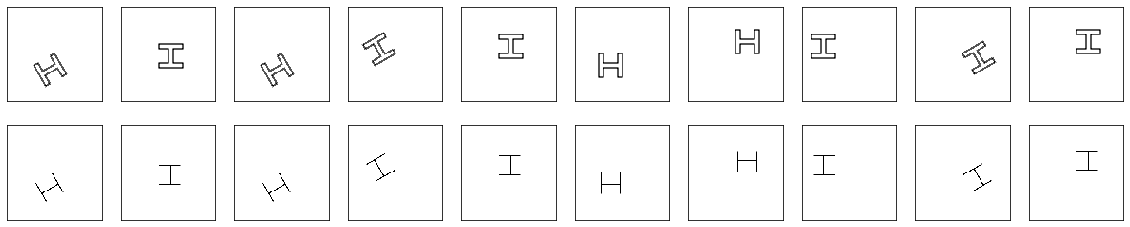

In [16]:
plot_results(profile_pngs_objs, midcurve_pngs_objs)

In [0]:
class simple_encoderdecoder:
    def __init__(self):
        self.encoding_dim = 100
        self.input_dim = 10000
        self.epochs = 200
        self.autoencoder_model_pkl = "models/autoencoder_model.pkl"
        self.encoder_model_pkl = "models/encoder_model.pkl"
        self.decoder_model_pkl = "models/decoder_model.pkl"
                
    def process_images(self,grayobjs):
        flat_objs = [x.reshape(self.input_dim) for x in grayobjs]
        pngs_objs = np.array(flat_objs)
        return pngs_objs

    def train(self,
            profile_pngs_gray_objs, 
            midcurve_pngs_gray_objs):
        
        if not os.path.exists(self.autoencoder_model_pkl):
            # this is our input placeholder
            input_img = Input(shape=(self.input_dim,))
            
            # "encoded" is the encoded representation of the input
            encoded = Dense(self.encoding_dim, activation='relu',activity_regularizer=regularizers.l1(10e-5))(input_img)
            # "decoded" is the lossy reconstruction of the input
            decoded = Dense(self.input_dim, activation='sigmoid')(encoded) 
            
            # Model 1: Full AutoEncoder, includes both encoder single dense layer and decoder single dense layer. 
            # This model maps an input to its reconstruction
            self.autoencoder = Model(input_img, decoded)
                    
            # Model 2: a separate encoder model: -------------------
            # this model maps an input to its encoded representation
            self.encoder = Model(input_img, encoded)
            
            # Model 3: a separate encoder model: -------------------
            # create a placeholder for an encoded (32-dimensional) input
            encoded_input = Input(shape=(self.encoding_dim,))
            # retrieve the last layer of the autoencoder model
            decoder_layer = self.autoencoder.layers[-1]
            # create the decoder model
            self.decoder = Model(encoded_input, decoder_layer(encoded_input))
            
            # Compilation of Autoencoder (only)
            self.autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
            
            profile_pngs_objs = self.process_images(profile_pngs_gray_objs)
            midcurve_pngs_objs = self.process_images(midcurve_pngs_gray_objs)
                
            self.x = profile_pngs_objs
            self.y = midcurve_pngs_objs
            self.autoencoder.fit(self.x, self.y,
                        epochs=self.epochs,
                        batch_size=5,
                        shuffle=True)                
            # Save models
            #self.autoencoder.save(self.autoencoder_model_pkl)
            #self.encoder.save(self.encoder_model_pkl)
            #self.decoder.save(self.decoder_model_pkl)  
        else:
            # Save models
            #self.autoencoder = load_model(self.autoencoder_model_pkl)
            #self.encoder= load_model(self.encoder_model_pkl)
            #self.decoder = load_model(self.decoder_model_pkl)
            print("pass...")
    
    def predict(self, test_profile_images):
        png_profile_images = self.process_images(test_profile_images)
        encoded_imgs = self.encoder.predict(png_profile_images)
        decoded_imgs = self.decoder.predict(encoded_imgs)    
        return test_profile_images,decoded_imgs

In [18]:
endec = simple_encoderdecoder()
endec.train(profile_pngs_objs, midcurve_pngs_objs)

W0821 16:25:06.238008 140569930655616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 16:25:06.263838 140569930655616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 16:25:06.268094 140569930655616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0821 16:25:06.306884 140569930655616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0821 16:25:06.326117 140569930655616 deprecation_wrappe

Epoch 1/200
3024/3024 [==============================] - 5s 2ms/step - loss: -3.6501
Epoch 2/200
3024/3024 [==============================] - 4s 1ms/step - loss: -6.7512
Epoch 3/200
3024/3024 [==============================] - 4s 1ms/step - loss: -6.8920
Epoch 4/200
3024/3024 [==============================] - 4s 1ms/step - loss: -6.8127
Epoch 5/200
3024/3024 [==============================] - 4s 1ms/step - loss: -6.7826
Epoch 6/200
3024/3024 [==============================] - 4s 1ms/step - loss: -6.7303
Epoch 7/200
3024/3024 [==============================] - 4s 1ms/step - loss: -6.7399
Epoch 8/200
3024/3024 [==============================] - 4s 1ms/step - loss: -6.6812
Epoch 9/200
3024/3024 [==============================] - 4s 1ms/step - loss: -6.6993
Epoch 10/200
3024/3024 [==============================] - 4s 1ms/step - loss: -6.6777
Epoch 11/200
3024/3024 [==============================] - 4s 1ms/step - loss: -6.6282
Epoch 12/200
3024/3024 [==============================] - 4s 1m

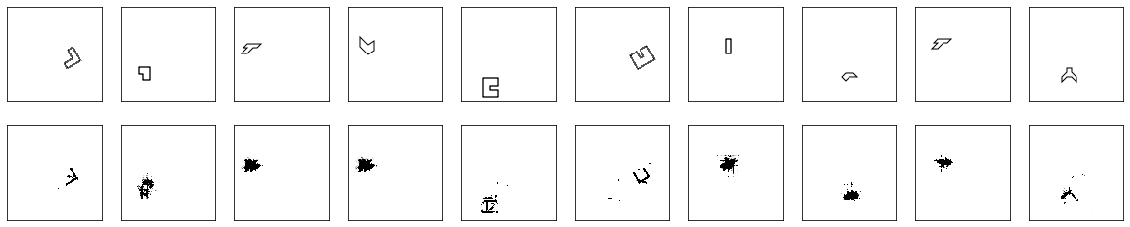

In [19]:
test_gray_images = random.sample(profile_pngs_objs, 10)
original_profile_imgs, predicted_midcurve_imgs = endec.predict(test_gray_images)

plot_results(original_profile_imgs, predicted_midcurve_imgs)

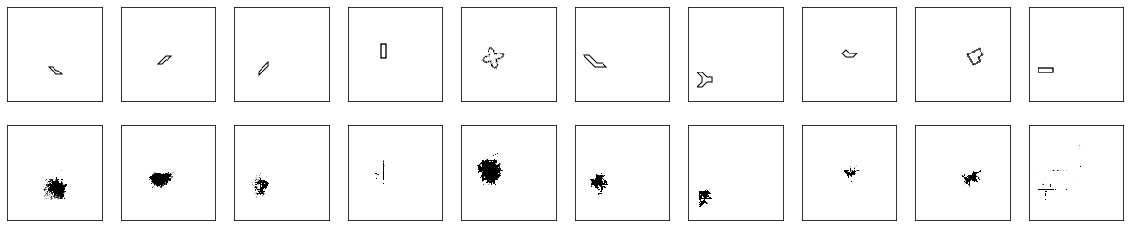

In [20]:
test_gray_images = random.sample(profile_pngs_objs, 10)
original_profile_imgs, predicted_midcurve_imgs = endec.predict(test_gray_images)

plot_results(original_profile_imgs, predicted_midcurve_imgs)

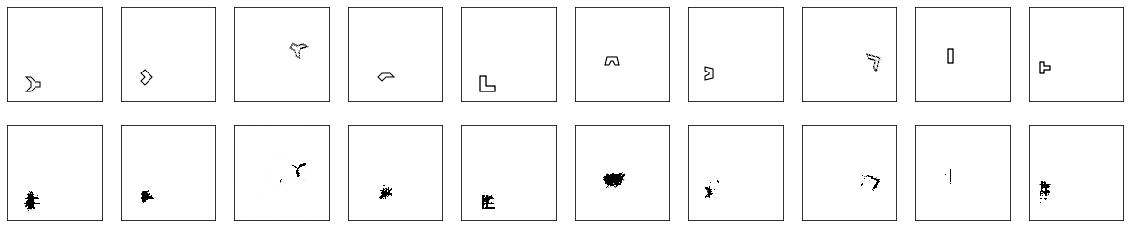

In [21]:
test_gray_images = random.sample(profile_pngs_objs, 10)
original_profile_imgs, predicted_midcurve_imgs = endec.predict(test_gray_images)

plot_results(original_profile_imgs, predicted_midcurve_imgs)